In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy

In [2]:
data_dir = '../../output/'

In [4]:
demand = pd.read_csv(data_dir+'MQ_halfhour_consumption.csv')
demand.head()

,Half_Hour,Total
0,0.0,0.0
1,0.5,0.0
2,1.0,0.0
3,1.5,0.0
4,2.0,0.0


In [26]:
demand_day = []
for i in demand.index:
    #print(i)
    if demand.Half_Hour[i] < 24:
        demand_day.append(demand.Total[i])
    else:
        demand_day[i-48] += demand.Total[i]

demand_day = np.array(demand_day)  
print(demand_day) # kW for each 30 min
len(demand_day)

[1893.478219   2056.23077    1691.956598   1769.438131   1504.440342
 1465.61351149 1089.134408   1010.7411407   821.195494    783.853568
  478.0161965   736.0309303   604.1958966   989.8107501  1717.177881
 2004.985034   2442.121156   3617.215455   4046.304313   4478.9724
 4974.627912   5280.016368   5418.873858   4526.461414   3820.192839
 3531.138524   3214.456372   3034.214606   3134.67138    3112.513631
 3454.095941   3649.381963   3636.941257   3860.695807   3966.708314
 4465.496913   4890.401732   4632.832575   4616.945959   4249.318171
 4723.606523   4165.327808   3632.209622   3296.140622   3801.920897
 2891.678708   2936.286409   2266.699337  ]


48

In [91]:
Capacity = 5000 # kWh
Duration = 4 # hr
Power = Capacity / Duration # kW

In [92]:
x = np.arange(48)/2

In [93]:
Depot_Demand = cp.Variable(48, nonneg = True) 
Battery_Input = cp.Variable(48, nonneg = False) 
SOC = cp.Variable(49, nonneg = True) 
Maximum_Demand = cp.Variable(1) 

obj =  cp.Minimize(Maximum_Demand)

con_set = []

con_set.append( Depot_Demand == demand_day + Battery_Input )
con_set.append( SOC <= Capacity )
con_set.append( Battery_Input <= Power )
con_set.append( Battery_Input >= -Power)
for i in range(48):
    con_set.append( SOC[i] + Battery_Input[i] * 0.5 == SOC[i+1])
con_set.append( SOC[0] == SOC[48])
con_set.append( Depot_Demand <= Maximum_Demand)

In [94]:
prob = cp.Problem(obj, con_set)
prob.solve(solver = "GUROBI")

4168.873858

In [95]:
Maximum_Demand.value

array([4168.873858])

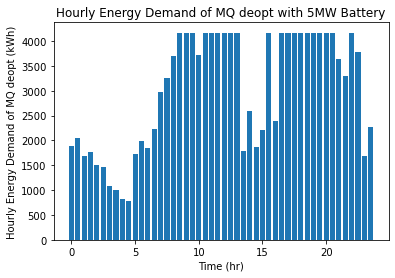

In [100]:
fig, ax = plt.subplots()
ax.bar(x, Depot_Demand.value, width = .4)
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Hourly Energy Demand of MQ deopt (kWh)")
ax.set_title("Hourly Energy Demand of MQ deopt with 5MW Battery")
ax.figure.savefig("../../fig/MQ_5MW_Battery.png", dpi = 200)

In [200]:
def battery_plotting(index, demand_before, demand_after, filename):
    
    demand_base = np.zeros(demand_before.shape)
    increase = np.zeros(demand_before.shape)
    decrease = np.zeros(demand_before.shape)
    
    for i in range(len(demand_before)):
        demand_base[i] = min(demand_before[i],demand_after[i])
        temp = demand_after[i] - demand_before[i]
        if temp >= 0:
            increase[i] = temp
        else:
            decrease[i] = -temp
    
    fig, ax = plt.subplots(figsize = (10,6))
    ax.bar(index, demand_base, width = 0.4, label = "Base Charger Demand")
    ax.bar(index, increase, width = 0.4, bottom = demand_base, label = "Increased Demand")
    ax.bar(index, decrease, width = 0.4, bottom = demand_base, label = "Decreased Demand")
    #ax.set_ylim(0, max(demand_before))
    ax.legend()
    ax.figure.savefig("../../fig/MQ_5MW_Battery_Comparison"+ filename +".png", dpi = 200)

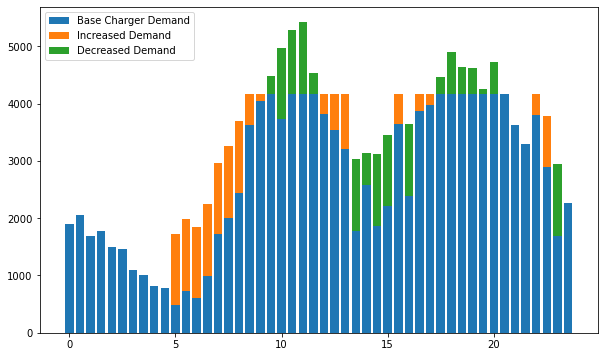

In [201]:
battery_plotting(x, demand_day, Depot_Demand.value, filename = "_Max")

In [202]:
# In this approach, opmitimizer will try it best to conduct overnight charging.
Depot_Demand2 = cp.Variable(48, nonneg = True) 
Battery_Input2 = cp.Variable(48, nonneg = False) 
SOC2 = cp.Variable(49, nonneg = True) 
Maximum_Demand2 = cp.Variable(1) 
Minimum_Demand2 = cp.Variable(1) 

obj2 =  cp.Minimize( sum(Depot_Demand2[8*2:22*2]) + 0.05 * (Maximum_Demand2 - Minimum_Demand2))

con_set2 = []

con_set2.append( Depot_Demand2 == demand_day + Battery_Input2 )
con_set2.append( SOC2 <= Capacity )
con_set2.append( Battery_Input2 <= Power )
con_set2.append( Battery_Input2 >= -Power)
for i in range(48):
    con_set2.append( SOC2[i] + Battery_Input2[i] * 0.5 == SOC2[i+1])
con_set2.append( SOC2[0] == SOC2[48])
con_set2.append( Depot_Demand2 <= Maximum_Demand2)
con_set2.append( Depot_Demand2 >= Minimum_Demand2)

In [203]:
prob2 = cp.Problem(obj2, con_set2)
prob2.solve(solver = "GUROBI")

101993.92631807501

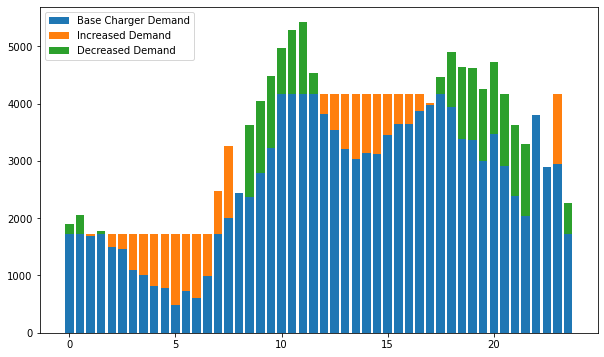

In [204]:
battery_plotting(x, demand_day, Depot_Demand2.value, filename = "Inte")